* Double descent curve for Random Fourier Features

** Standard input

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
from caffe2.python.layers.random_fourier_features import RandomFourierFeatures 
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


** Load and setup datasets

In [57]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, sampler

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                transforms.Lambda(lambda img: img.reshape(-1))])
#transform = None
mnist_trainset = datasets.MNIST(root='./data',
                                download=True,
                                train=True,
                                transform=transform)
train_subset_size = int(4e3)
val_subset_size = int(0.2 * train_subset_size)
random_train_indices = np.random.randint(len(mnist_trainset),
                                         size=train_subset_size)
random_val_indices = np.random.choice([x for x in range(len(mnist_trainset))
                                       if x not in random_train_indices],
                                      size=val_subset_size)
mnist_trainloader = DataLoader(mnist_trainset,
                               batch_size=64,
                               num_workers=4,
                               sampler=sampler.SubsetRandomSampler(random_train_indices))
mnist_valloader = DataLoader(mnist_trainset,
                             batch_size=64,
                             num_workers=4,
                             sampler=sampler.SubsetRandomSampler(random_val_indices))
mnist_testset = datasets.MNIST(root='./data',
                               download=True,
                               train=False,
                               transform=transform)
mnist_testloader = DataLoader(mnist_testset,
                              batch_size=32,
                              shuffle=False,
                              num_workers=2)

In [58]:
import nets
from nets import TwoLayerNN


In [59]:
# some constants
num_classes = 10
input_dim = 28 * 28
interpolation_threshold = num_classes * subset_size
max_epochs = 600
num_hidden = list(range(5, 10, 2))
num_hidden += list(range(10, 25, 5))
num_hidden += list(range(25, 40, 2))
num_hidden += list(range(40, 55, 1))
num_hidden += list(range(55, 80, 5))
num_hidden += list(range(80, 1000, 200))


In [5]:
mnist_nets = []
for h in num_hidden:
    net = TwoLayerNN(input_dim, h, num_classes)
    mnist_nets.append(net)


In [62]:
import os
import torch.optim as optimizers
from torch.optim.lr_scheduler import MultiStepLR
from nets import initialize_with_previous_weights, initialize_with_previous_bias

loss_function = nn.CrossEntropyLoss()
all_train_losses = {}
all_val_losses = {}
all_test_losses = {}
print("=" * 30)
print("TRAINING {} NETS".format(len(mnist_nets)))
for i, net in enumerate(mnist_nets[:1]):
    print("-" * 30)
    print("Training net {} of {}".format(i + 1, len(mnist_nets)))
    if net == mnist_nets[0]:
        # initialize smallest net using Xavier Glorot-uniform distribution
        gain = nn.init.calculate_gain("relu")
        nn.init.xavier_uniform_(net.hidden.weight, gain=gain)
        nn.init.xavier_uniform_(net.out.weight, gain=gain) # or only for hidden?
    else:
        nn.init.normal_(net.hidden.weight, 0, 0.01)
        initialize_with_previous_weights(net.hidden.weight, nets[i-1].hidden.weight)
        initialize_with_previous_bias(net.hidden.bias, nets[i-1].hidden.bias)
        nn.init.normal_(net.out.weight, 0, 0.01)
            
    # init learning rate not clear
    optimizer = optimizers.SGD(net.parameters(), lr=0.001, momentum=0.95)
    scheduler = MultiStepLR(optimizer, milestones=list(range(500, 6000, 500)), gamma=0.9)
    train_losses = []
    val_losses = []
    for epoch in range(max_epochs):
        running_loss = 0.0
        net.train()
        for data in mnist_trainloader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(mnist_trainloader))
        
        if net.num_parameters() < interpolation_threshold:
            scheduler.step()

        net.eval()
        running_val_loss = 0.0
        for data in mnist_valloader:
            images, labels = data
            outputs = net(images)
            loss = loss_function(outputs, labels)
            running_val_loss += loss.item()
        val_losses.append(running_val_loss / len(mnist_valloader))
        if epoch % 20 == 0:
            print("+" * 30)
            print("Finished epoch {} of {}".format(epoch + 1, max_epochs))
            print("Training loss is: {}".format(train_losses[-1]))
            print("Validation loss is: {}".format(val_losses[-1]))

        if train_losses[-1] == 0.0 and net.num_parameters() < interpolation_threshold:
            break
                    
    print("=" * 30)
    print("Finished training network with {} parameters".format(net.num_parameters()))
    print("Final train/val loss: {}/{}".format(train_losses[-1], val_losses[-1]))
    net_name = "mnist_net_{}".format(net.num_parameters())
    path = os.path.join("data", "nets", net_name)
    print("Saving network to \"{}\"".format(path))
    torch.save(net.state_dict(), path)
    all_train_losses[net_name] = train_losses
    all_val_losses[net_name] = val_losses
    print("Evaluating net on test set...")
    net.eval()
    running_test_loss = 0.0
    for data in mnist_testloader:
        images, labels = data
        outputs = net(images)
        loss = loss_function(outputs, labels)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_loss = running_test_loss / len(mnist_testloader)
    print("Testloss is: {}".format(test_loss))
    print("Accuracy is: {}".format(correct/total))
    all_test_losses[net_name] = test_loss


TRAINING 39 NETS
------------------------------
Training net 1 of 39


++++++++++++++++++++++++++++++
Finished epoch 1 of 600
Training loss is: 4.085596656042432
Validation loss is: 3.371214958337637


++++++++++++++++++++++++++++++
Finished epoch 21 of 600
Training loss is: 0.7103262382840353
Validation loss is: 0.8553328422399668


++++++++++++++++++++++++++++++
Finished epoch 41 of 600
Training loss is: 0.4680971172120836
Validation loss is: 0.6851498438761785


++++++++++++++++++++++++++++++
Finished epoch 61 of 600
Training loss is: 0.38066816566482425
Validation loss is: 0.6625151565441718


++++++++++++++++++++++++++++++
Finished epoch 81 of 600
Training loss is: 0.33322080685978844
Validation loss is: 0.6509071886539459


++++++++++++++++++++++++++++++
Finished epoch 101 of 600
Training loss is: 0.2954488134100324
Validation loss is: 0.6674851775169373


++++++++++++++++++++++++++++++
Finished epoch 121 of 600
Training loss is: 0.2623567117585076
Validation loss is: 0.7031504924480731


++++++++++++++++++++++++++++++
Finished epoch 141 of 600
Training loss is: 0.23188410096225284
Validation loss is: 0.7175009892537043


++++++++++++++++++++++++++++++
Finished epoch 161 of 600
Training loss is: 0.21146953094100196
Validation loss is: 0.723048047377513


++++++++++++++++++++++++++++++
Finished epoch 181 of 600
Training loss is: 0.19120921572995564
Validation loss is: 0.7705308909599597


++++++++++++++++++++++++++++++
Finished epoch 201 of 600
Training loss is: 0.17855619154279195
Validation loss is: 0.8075826076360849


++++++++++++++++++++++++++++++
Finished epoch 221 of 600
Training loss is: 0.16538124058454756
Validation loss is: 0.8427844185095567


++++++++++++++++++++++++++++++
Finished epoch 241 of 600
Training loss is: 0.15208966521516679
Validation loss is: 0.8536070493551401


++++++++++++++++++++++++++++++
Finished epoch 261 of 600
Training loss is: 0.14639154508236854
Validation loss is: 0.8781867164831895


++++++++++++++++++++++++++++++
Finished epoch 281 of 600
Training loss is: 0.1335924475320748
Validation loss is: 0.8740232380536886


++++++++++++++++++++++++++++++
Finished epoch 301 of 600
Training loss is: 0.12607225184402768
Validation loss is: 0.9303126633167267


++++++++++++++++++++++++++++++
Finished epoch 321 of 600
Training loss is: 0.11783458416660626
Validation loss is: 0.9545615934408628


++++++++++++++++++++++++++++++
Finished epoch 341 of 600
Training loss is: 0.10974468426808479
Validation loss is: 0.9839032773788159


++++++++++++++++++++++++++++++
Finished epoch 361 of 600
Training loss is: 0.10302954640180345
Validation loss is: 1.0680964038922236


++++++++++++++++++++++++++++++
Finished epoch 381 of 600
Training loss is: 0.09780942506733395
Validation loss is: 1.1269128047502959


++++++++++++++++++++++++++++++
Finished epoch 401 of 600
Training loss is: 0.0953085669094608
Validation loss is: 1.1448192435961504


++++++++++++++++++++++++++++++
Finished epoch 421 of 600
Training loss is: 0.08949211600517469
Validation loss is: 1.14862417945495


++++++++++++++++++++++++++++++
Finished epoch 441 of 600
Training loss is: 0.08447252953099826
Validation loss is: 1.1444910168647766


++++++++++++++++++++++++++++++
Finished epoch 461 of 600
Training loss is: 0.08029227133189874
Validation loss is: 1.2345585502110994


++++++++++++++++++++++++++++++
Finished epoch 481 of 600
Training loss is: 0.0761659165164308
Validation loss is: 1.2872288089532118


++++++++++++++++++++++++++++++
Finished epoch 501 of 600
Training loss is: 0.07381408856738181
Validation loss is: 1.2585127766315753


++++++++++++++++++++++++++++++
Finished epoch 521 of 600
Training loss is: 0.06931588024137512
Validation loss is: 1.3109162908333998


++++++++++++++++++++++++++++++
Finished epoch 541 of 600
Training loss is: 0.06722445889479584
Validation loss is: 1.3375308490716493


++++++++++++++++++++++++++++++
Finished epoch 561 of 600
Training loss is: 0.06429253645714313
Validation loss is: 1.402541797894698


++++++++++++++++++++++++++++++
Finished epoch 581 of 600
Training loss is: 0.0634354314219857
Validation loss is: 1.4350191904948308


Finished training network with 3985 parameters
Final train/val loss: 0.05954038010289272
Saving network to "data/nets/mnist_net_3985"


FileNotFoundError: [Errno 2] No such file or directory: 'data/nets/mnist_net_3985'

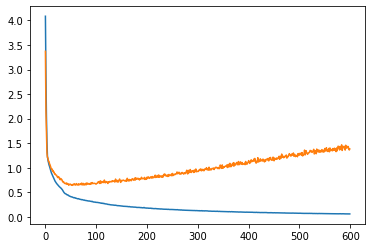

In [64]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()